# **Training Model CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

Penjelasan:

- torch: Inti PyTorch untuk tensor dan komputasi otomatis (autograd).
- torch.nn: Modul untuk membangun arsitektur model (layer, loss function).
- torch.optim: Optimizer seperti Adam, SGD untuk memperbarui bobot.
- torchvision.datasets & transforms: Untuk mengakses dataset (seperti FashionMNIST) dan pra-pemrosesan data.
- DataLoader: Untuk memuat data dalam batch dan mengacak (shuffle) data pelatihan.
- matplotlib & numpy: Visualisasi dan manipulasi numerik.
sklearn.metrics: Untuk evaluasi kinerja model (akurasi per kelas, confusion matrix).

## **Load Dataset (FashionMNIST)**

In [ ]:
print("Loading dataset...")
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Loading dataset...


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.8MB/s]


Penjelasan:

- transforms.ToTensor(): Mengubah gambar PIL (0–255, uint8) ke tensor PyTorch (0–1, float32) dan ubah bentuk ke [C, H, W] = [1, 28, 28].
- FashionMNIST:
> - Dataset berisi 60.000 gambar pelatihan + 10.000 gambar uji.
> - 10 kelas pakaian (e.g., T-shirt, Trouser, Pullover, Dress, Coat, Sandal, dll).
- DataLoader:
> - batch_size=64: Proses 64 gambar sekaligus → lebih efisien dan stabil untuk optimisasi.
> - shuffle=True (hanya train): Hindari bias urutan data saat pelatihan.

## **Tampilkan Beberapa Contoh Gambar**

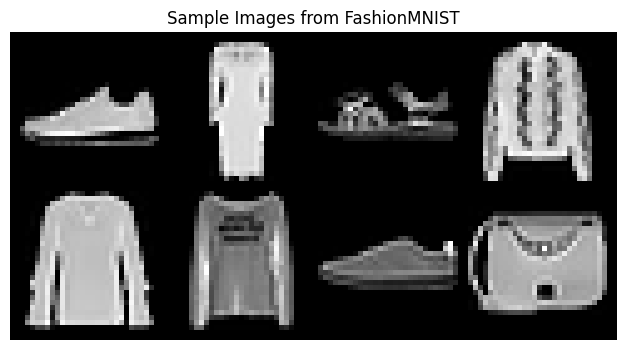

In [ ]:
def show_sample_images(dataloader, num_images=8):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4, padding=2)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title("Sample Images from FashionMNIST")
    plt.show()

show_sample_images(train_loader)

Penjelasan:

- next(iter(dataloader)): Ambil satu batch pertama.
make_grid(...): Gabungkan beberapa gambar jadi satu grid (4 kolom).
- grid.permute(1,2,0): Ubah urutan dimensi dari [C,H,W] → [H,W,C] agar cocok untuk matplotlib.

Tujuan: Verifikasi bahwa data dimuat dengan benar dan visualisasi contoh input

## **Definisi Model CNN**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv -> ReLU -> Pool
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)  # Fully connected
        return x

model = SimpleCNN()

### Detail Arsitektur Model

| Layer                      | Input Shape        | Output Shape         | Catatan                                      |
|----------------------------|--------------------|----------------------|----------------------------------------------|
| `Conv2d(1→32, 3×3, pad=1)` | `(B, 1, 28, 28)`   | `(B, 32, 28, 28)`    | Padding=1 → ukuran spasial tetap             |
| `ReLU`                     | —                  | `(B, 32, 28, 28)`    | Aktivasi non-linear                          |
| `MaxPool2d(2×2, stride=2)` | —                  | `(B, 32, 14, 14)`    | Downsampling → tinggi & lebar ÷2             |
| `Flatten`                  | —                  | `(B, 6272)`          | `32 × 14 × 14 = 6272` → siap ke FC layer     |
| `Linear(6272 → 10)`        | —                  | `(B, 10)`            | Output *logits* (belum softmax)              |

 **Catatan**:
 - B = ukuran *batch* (misal: 64)
 - Input gambar FashionMNIST: grayscale → 1 channel, 28×28 piksel
 - Tidak ada *BatchNorm* atau *Dropout* → model sangat sederhana (baseline)

## **Inisiasi Loss Function dan Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

- CrossEntropyLoss:
> - Menggabungkan log_softmax + NLLLoss.
> - Cocok untuk klasifikasi multi-kelas.
> - Menerima logits langsung (tidak perlu softmax manual).
- Adam(lr=0.001):
> - Optimizer adaptif (mengatur learning rate per parameter).
> - lr=1e-3 adalah nilai umum dan cukup baik untuk baseline.

## **Mendefinisikan Training Model**

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = total_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total

        # Evaluasi (Validation)
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(test_loader)
        epoch_val_acc = 100 * correct_val / total_val

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

Alur pelatihan per epoch:

- Training Phase (model.train()):
> - Loop tiap batch:
>> - optimizer.zero_grad(): Kosongkan gradien sebelum backward.
>> - outputs = model(images): Forward pass.
>> - loss = criterion(...): Hitung loss.
>> - loss.backward(): Hitung gradien.
>> - optimizer.step(): Perbarui bobot.
>> - Hitung akurasi batch dan akumulasi loss.
- Validation/Evaluation Phase (model.eval()):
> - Gunakan torch.no_grad() untuk hemat memori & kecepatan (tidak hitung gradien).
> - Evaluasi di test set sebagai proxy validasi (sebenarnya seharusnya pakai validation set, tapi di sini test set dipakai ganda).
- Log & Return metrics:
> - Simpan loss & akurasi tiap epoch untuk visualisasi.

## **Menjalankan Training**

In [ ]:
print("\nStarting training...")
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, epochs=5
)


Starting training...
Epoch [1/5], Train Loss: 0.4607, Train Acc: 83.78%, Val Loss: 0.3887, Val Acc: 86.27%
Epoch [2/5], Train Loss: 0.3186, Train Acc: 88.82%, Val Loss: 0.3282, Val Acc: 88.56%
Epoch [3/5], Train Loss: 0.2832, Train Acc: 89.87%, Val Loss: 0.3045, Val Acc: 89.24%
Epoch [4/5], Train Loss: 0.2624, Train Acc: 90.65%, Val Loss: 0.3162, Val Acc: 88.53%
Epoch [5/5], Train Loss: 0.2431, Train Acc: 91.28%, Val Loss: 0.2999, Val Acc: 89.33%


Observasi:

- Akurasi meningkat stabil → model belajar dengan baik.
- Tidak ada tanda overfitting berat (gap train-val masih kecil).

## **Visualisasi Grafik Training**

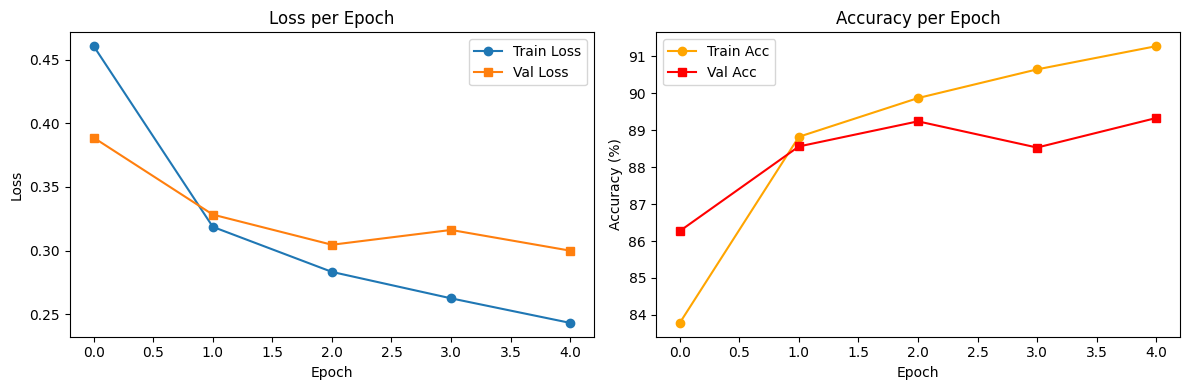

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc', marker='o', color='orange')
plt.plot(val_accuracies, label='Val Acc', marker='s', color='red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

**Grafik Loss per Epoch**

Grafik ini menunjukkan bagaimana nilai loss (kesalahan) model berubah seiring bertambahnya jumlah epoch (satu putaran penuh melalui seluruh dataset pelatihan).

- Sumbu Y (Loss): Nilai loss semakin kecil artinya model semakin baik dalam memprediksi label yang benar.
- Sumbu X (Epoch): Jumlah iterasi pelatihan.

Penjelasan Per Garis:
- Train Loss (Biru):
> - Menunjukkan rata-rata loss pada data pelatihan (training set) di akhir setiap epoch.
> - Tren: Turun secara konsisten dari ~0.46 di epoch 0 menjadi ~0.24 di epoch 4.
> - Interpretasi: Model belajar dengan baik. Setiap kali bobot diperbarui, model menjadi lebih mampu meminimalkan kesalahan pada data yang sudah ia lihat.
- Val Loss (Oranye):
> - Menunjukkan rata-rata loss pada data validasi (test set, digunakan sebagai validasi di sini) di akhir setiap epoch.
> - Tren: Juga turun secara umum, meskipun tidak selalu mulus (ada sedikit naik di epoch 3 dan 4).
> - Interpretasi: Model juga memperbaiki kemampuannya untuk memprediksi data yang belum pernah ia lihat sebelumnya. Ini adalah indikator bahwa model tidak hanya menghafal (overfitting) tetapi benar-benar belajar pola.

Kesimpulan Grafik Loss:
- Pelatihan berjalan sehat: Baik train loss maupun val loss menurun, yang menandakan model belajar dan generalisasi.
- Tidak ada overfitting parah: Meskipun train loss selalu lebih rendah dari val loss (yang wajar), perbedaan antara keduanya tidak melebar secara drastis. Ini menunjukkan model masih bisa bekerja baik pada data baru.

**Grafik Accuracy per Epoch**

Grafik ini menunjukkan bagaimana akurasi (persentase prediksi yang benar) model meningkat seiring waktu.

- Sumbu Y (Accuracy %): Semakin tinggi, semakin baik.
- Sumbu X (Epoch): Sama seperti grafik loss.

Penjelasan Per Garis:
- Train Acc (Kuning):
> - Akurasi pada data pelatihan.
> - Tren: Meningkat terus dari 83.8% di epoch 0 menjadi 91.3% di epoch 4.
Interpretasi: Model menjadi lebih pintar dalam memprediksi data yang sudah ia pelajari.
- Val Acc (Merah, persegi):
> - Akurasi pada data validasi (test set).
> - Tren: Meningkat dari 86.3% di epoch 0, mencapai puncak 89.2% di epoch 2, lalu turun sedikit di epoch 3 (88.5%), dan naik lagi di epoch 4 (89.3%).
> - Interpretasi: Model berhasil mencapai akurasi tinggi pada data baru, meskipun ada fluktuasi kecil. Fluktuasi ini bisa disebabkan oleh stochasticity (acaknya pemilihan batch) atau karena model sedang menyesuaikan diri.

Kesimpulan Grafik Accuracy:
- Model belajar dengan cepat: Akurasi naik signifikan hanya dalam 5 epoch.
- Generalisasi baik: Akurasi validasi tinggi (~89%) menunjukkan model bisa dipercaya untuk data baru.
- Stabil: Tidak ada penurunan drastis di akhir, yang berarti model tidak overfitting meskipun pelatihan berlanjut.

## **Evaluasi Model**


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.91      0.73      0.81      1000
           3       0.89      0.91      0.90      1000
           4       0.73      0.93      0.82      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.68      0.70      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



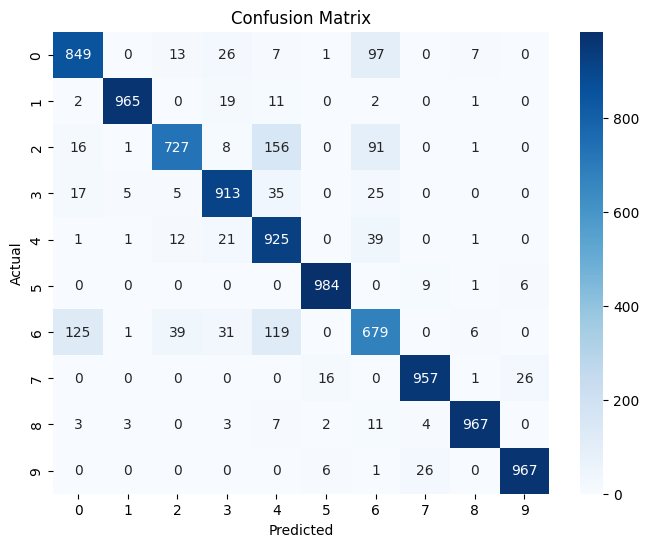

In [ ]:
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Classification Report**

Classification Report adalah laporan ringkas yang memberikan metrik evaluasi kinerja model klasifikasi secara rinci per kelas. Ini lebih informatif daripada hanya melihat akurasi keseluruhan karena menunjukkan bagaimana model bekerja untuk setiap kategori individu.

Laporan ini terdiri dari empat kolom utama:
- Precision (Ketepatan prediksi) : Dari semua sampel yang diprediksi sebagai kelas X, berapa persen yang benar-benar termasuk kelas X?
- Recall (Kelengkapan deteksi) : Dari semua sampel sebenarnya kelas X, berapa persen yang berhasil dikenali oleh model?
- F1-score (Rata-rata harmonik dari precision dan recall) : Memberikan gambaran seimbang antara ketepatan dan kelengkapan.
- Support: Jumlah sampel aktual dalam kelas tersebut (dalam hal ini, 1000 untuk setiap kelas).

**Kelas dengan Performa Sangat Baik (Precision & Recall > 0.95)**

- Kelas 1 (Trouser): Precision=0.99, Recall=0.96 → Hampir sempurna. Model sangat tepat dan lengkap dalam mendeteksi celana.
- Kelas 5 (Sandal): Precision=0.98, Recall=0.98 → Sempurna.
- Kelas 7 (Sneaker): Precision=0.96, Recall=0.96 → Sangat baik.
- Kelas 8 (Bag): Precision=0.98, Recall=0.97 → Hampir sempurna.
- Kelas 9 (Ankle boot): Precision=0.97, Recall=0.97 → Sangat baik.

Insight: Objek dengan bentuk sangat unik (celana panjang, sandal, sepatu olahraga, tas, sepatu bot) mudah dibedakan oleh model.

**Kelas dengan Masalah (Precision atau Recall < 0.85)**

- Kelas 6 (Shirt):
> - Precision = 0.72: Hanya 72% dari prediksi "shirt" yang benar. Artinya, banyak benda lain (misalnya T-shirt atau Pullover) yang salah diprediksi sebagai Shirt.
> - Recall = 0.68: Hanya 68% dari semua shirt asli yang berhasil dikenali. Artinya, banyak shirt nyata yang tidak terdeteksi.
> - F1-Score = 0.70: Nilai terendah di antara semua kelas → ini adalah kelas paling bermasalah!
- Kelas 2 (Pullover):
> - Recall = 0.73: Hanya 73% dari pullover asli yang terdeteksi → banyak yang dilewatkan.
> - Precision = 0.91: Relatif tinggi → jika model memprediksi "pullover", kemungkinan besar benar.
> - F1-Score = 0.81: Masih cukup baik, tapi recall rendah menjadi kelemahan.
- Kelas 4 (Coat):
> - Precision = 0.73: Rendah → banyak benda lain (misalnya Pullover atau Shirt) yang salah diprediksi sebagai Coat.
> - Recall = 0.93: Tinggi → hampir semua coat asli berhasil dikenali.
> - F1-Score = 0.82: Masih bisa diterima, tapi precision rendah menunjukkan model sering "terlalu percaya diri" memanggil sesuatu "coat".
- Kelas 0 (T-shirt/top):
> - Precision = 0.84, Recall = 0.85 → Cukup baik, tapi masih ada ruang untuk perbaikan.
> - F1-Score = 0.84: Sedikit lebih rendah dari kelas lain.


# **Confusion Matrix**

Confusion Matrix adalah tabel berukuran K × K (dengan K = jumlah kelas) yang menunjukkan jumlah prediksi benar dan salah model untuk setiap kelas.
- Baris = label sebenarnya (actual), Kolom = prediksi model (predicted).
- Setiap sel (i, j) = jumlah sampel yang sebenarnya kelas i, tapi diprediksi sebagai kelas j.

Manfaat Confusion Matrix:

- Mengidentifikasi kelas mana yang sulit dibedakan.
- Menemukan pola kesalahan sistematis → bisa jadi masukan untuk perbaikan (augmentasi, fitur baru).

Dari kode diperoleh:
- Menghasilkan heatmap 10×10 (karena FashionMNIST punya 10 kelas: 0–9).
- Angka di diagonal utama (i = j): prediksi benar (true positives per kelas).
- Angka di luar diagonal: kesalahan klasifikasi (misal: kelas 2 → kelas 0).

Kelas 0–9 sesuai dengan:

- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

**Kelas yang Sangat Baik (Prediksi Benar Tinggi)**
- Kelas 1 (Trouser): 965 (diagonal) — Hampir semua celana berhasil dikenali. Hanya 2 kali salah prediksi sebagai kelas 0 (T-shirt).
- Kelas 5 (Sandal): 984 — Sangat akurat. Hanya 9 kali salah prediksi sebagai kelas 7 (Sneaker) atau 9 (Ankle boot).
- Kelas 7 (Sneaker): 957 — Sangat bagus, hanya 16 kali salah prediksi sebagai kelas 5 (Sandal).
- Kelas 8 (Bag): 967 — Hampir sempurna.
- Kelas 9 (Ankle boot): 967 — Sangat akurat.

Insight: Objek dengan bentuk sangat unik (celana panjang, sandal, sepatu olahraga, tas, sepatu bot) mudah dibedakan oleh model.

**Kelas yang Bermasalah (Banyak Kesalahan)**

- Kelas 0 (T-shirt/top):
> - Benar: 849
> - Salah: 13 + 26 + 7 + 1 + 97 + 7 = 151 (total 1000 sampel)
Kesalahan Utama:
> - Diprediksi sebagai kelas 6 (Shirt) → 97 kali.
> - Diprediksi sebagai kelas 3 (Dress) → 26 kali.
> - Diprediksi sebagai kelas 2 (Pullover) → 13 kali.

> Interpretasi: Model sering bingung antara T-shirt, Shirt, dan Dress karena bentuknya mirip (semua atasan).

- Kelas 2 (Pullover):
> - Benar: 727
> - Salah: 16 + 1 + 8 + 156 + 91 + 1 = 273
Kesalahan Utama:
> - Diprediksi sebagai kelas 4 (Coat) → 156 kali.
> - Diprediksi sebagai kelas 6 (Shirt) → 91 kali.
>- Diprediksi sebagai kelas 0 (T-shirt) → 16 kali.

> Interpretasi: Pullover (sweater) dan Coat (mantel) memiliki bentuk serupa (atasan longgar), sehingga model sulit membedakannya.

- Kelas 4 (Coat):
> Benar: 925
> Salah: 1 + 1 + 12 + 21 + 39 + 1 = 75
Kesalahan Utama:
> - Diprediksi sebagai kelas 6 (Shirt) → 39 kali.
> - Diprediksi sebagai kelas 2 (Pullover) → 12 kali.

> Interpretasi: Meskipun coat cukup akurat, model masih sering tertukar dengan pullover dan shirt.

- Kelas 6 (Shirt):
> Benar: 679
> Salah: 125 + 1 + 39 + 31 + 119 + 6 = 321
Kesalahan Utama:
> - Diprediksi sebagai kelas 0 (T-shirt) → 125 kali.
> - Diprediksi sebagai kelas 4 (Coat) → 119 kali.
> - Diprediksi sebagai kelas 2 (Pullover) → 39 kali.

> Interpretasi: Ini adalah kelas paling bermasalah! Shirt memiliki bentuk paling ambigu — bisa tertukar dengan T-shirt, Pullover, atau Coat. Ini juga terlihat di classification report (precision dan recall rendah).

# **Latihan**

1. Bagaimana jika learning rate diubah menjadi lebih kecil (misalnya 0.000001)?
2. Bagaimana jika jumlah epoch ditambahkan?
3. Berikan kesimpulan yang menjelaskan perbedaan sebelum dan setelah diubah lr dan epoch.